# Electrode Labelling

Label intracranial EEG electrode contacts using freesurfer segmentation files.

In [1]:
import numpy as np
import nibabel as nib
from mne._freesurfer import _get_aseg, read_freesurfer_lut
from mne.channels import DigMontage
from collections import OrderedDict
from mne.transforms import apply_trans


# *************** LABELLING FUNCTIONS ***************

def get_montage_volume_labels(montage, subject, subjects_dir=None, image="auto", dist=2, lut_fname=None):
    """Get regions of interest near channels from a Freesurfer parcellation.

    .. note:: This is applicable for channels inside the brain
              (intracranial electrodes).

    Parameters
    ----------
    %(montage)s
    %(subject)s
    %(subjects_dir)s
    %(aseg)s
    dist : float
        The distance in mm to use for identifying regions of interest.

    Returns
    -------
    labels : dict
        The regions of interest labels within ``dist`` of each channel.
    colors : dict
        The Freesurfer lookup table colors for the labels.
    """
    
    _VOXELS_MAX = 1000  # define constant to avoid runtime issues

    # _validate_type(montage, DigMontage, "montage")
    # _validate_type(dist, (int, float), "dist")

    if dist < 0 or dist > 10:
        raise ValueError("`dist` must be between 0 and 10")

    # aseg, aimg_data = _get_aseg(aseg, subject, subjects_dir)
    img = nib.load(f"{subjects_dir}/{subject}/mri/{image}.mgz")
    img_data = np.array(img.dataobj)

    # read freesurfer lookup table
    lut, fs_colors = read_freesurfer_lut(fname=lut_fname)
    label_lut = {v: k for k, v in lut.items()}

    # assert that all the labels/values in the image segment file are in the freesurfer lookup table
    assert all([idx in label_lut for idx in np.unique(img_data)])

    # get transform to surface RAS for distance units instead of voxels
    vox2ras_tkr = img.header.get_vox2ras_tkr()

    ch_dict = montage.get_positions()
    if ch_dict["coord_frame"] != "mri":
        raise RuntimeError(
            "Coordinate frame not supported, expected "
            '"mri", got ' + str(ch_dict["coord_frame"])
        )
    ch_coords = np.array(list(ch_dict["ch_pos"].values()))

    # convert electrode coordinates to freesurfer voxel space
    ch_coords = apply_trans(
        np.linalg.inv(img.header.get_vox2ras_tkr()), ch_coords * 1000
    )
    labels = OrderedDict()
    for ch_name, ch_coord in zip(montage.ch_names, ch_coords):
        if np.isnan(ch_coord).any():
            labels[ch_name] = list()
        else:
            voxels = _voxel_neighbors(
                seed=ch_coord,
                image=img_data,
                dist=dist,
                vox2ras_tkr=vox2ras_tkr,
                voxels_max=_VOXELS_MAX,
            )
            label_idxs = set([img_data[tuple(voxel)].astype(int) for voxel in voxels])
            labels[ch_name] = [label_lut[idx] for idx in label_idxs]
    
    all_labels = set([label for val in labels.values() for label in val])
    colors = {label: tuple(fs_colors[label][:3] / 255) + (1.0,) for label in all_labels}
    labels = {k: v[0] if len(v) == 1 else '|'.join(v) for k, v in labels.items()}
    return labels, colors, voxels, label_idxs, label_lut

def _voxel_neighbors(
    seed,
    image,
    thresh=None,
    max_peak_dist=1,
    use_relative=True,
    dist=None,
    vox2ras_tkr=None,
    voxels_max=100,
):
    """Find voxels above a threshold contiguous with a seed location.

    Parameters
    ----------
    seed : tuple | ndarray
        The location in image coordinates to seed the algorithm.
    image : ndarray
        The image to search.
    thresh : float
        The threshold to use as a cutoff for what qualifies as a neighbor.
        Will be relative to the peak if ``use_relative`` or absolute if not.
    max_peak_dist : int
        The maximum number of voxels to search for the peak near
        the seed location.
    use_relative : bool
        If ``True``, the threshold will be relative to the peak, if
        ``False``, the threshold will be absolute.
    dist : float
        The distance in mm to include surrounding voxels.
    vox2ras_tkr : ndarray
        The voxel to surface RAS affine. Must not be None if ``dist``
        is not None.
    voxels_max : int
        The maximum size of the output ``voxels``.

    Returns
    -------
    voxels : set
        The set of locations including the ``seed`` voxel and
        surrounding that meet the criteria.

    .. note:: Either ``dist`` or ``thesh`` may be used but not both.
              When ``thresh`` is used, first a peak nearby the seed
              location is found and then voxels are only included if they
              decrease monotonically from the peak. When ``dist`` is used,
              only voxels within ``dist`` mm of the seed are included.
    """
    seed = np.array(seed).round().astype(int)
    assert ((dist is not None) + (thresh is not None)) == 1
    if thresh is not None:
        dist_params = None
        check_grid = image[
            tuple([slice(idx - max_peak_dist, idx + max_peak_dist + 1) for idx in seed])
        ]
        peak = (
            np.array(np.unravel_index(np.argmax(check_grid), check_grid.shape))
            - max_peak_dist
            + seed
        )
        voxels = neighbors = set([tuple(peak)])
        if use_relative:
            thresh *= image[tuple(peak)]
    else:
        assert vox2ras_tkr is not None
        seed_fs_ras = apply_trans(vox2ras_tkr, seed + 0.5)  # center of voxel
        dist_params = (dist, seed_fs_ras, vox2ras_tkr)
        voxels = neighbors = set([tuple(seed)])
    while neighbors and len(voxels) <= voxels_max:
        next_neighbors = set()
        for next_loc in neighbors:
            voxel_neighbors = _get_neighbors(
                next_loc, image, voxels, thresh, dist_params
            )
            # prevent looping back to already visited voxels
            voxel_neighbors = voxel_neighbors.difference(voxels)
            # add voxels not already visited to search next
            next_neighbors = next_neighbors.union(voxel_neighbors)
            # add new voxels that match the criteria to the overall set
            voxels = voxels.union(voxel_neighbors)
            if len(voxels) > voxels_max:
                break
        neighbors = next_neighbors  # start again checking all new neighbors
    return voxels

def _get_neighbors(loc, image, voxels, thresh, dist_params):
    """Find all the neighbors above a threshold near a voxel."""
    neighbors = set()
    for axis in range(len(loc)):
        for i in (-1, 1):
            next_loc = np.array(loc)
            next_loc[axis] += i
            if thresh is not None:
                assert dist_params is None
                # must be above thresh, monotonically decreasing from
                # the peak and not already found
                next_loc = tuple(next_loc)
                if (
                    image[next_loc] > thresh
                    and image[next_loc] <= image[loc]
                    and next_loc not in voxels
                ):
                    neighbors.add(next_loc)
            else:
                assert thresh is None
                dist, seed_fs_ras, vox2ras_tkr = dist_params
                next_loc_fs_ras = apply_trans(vox2ras_tkr, next_loc + 0.5)
                if np.linalg.norm(seed_fs_ras - next_loc_fs_ras) <= dist:
                    neighbors.add(tuple(next_loc))
    return neighbors

In [2]:
import neuropsy as npsy
from mne.transforms import read_trans


# *************** DEFINES ***************
# paths
# path_data       = 'C:/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
# subjects_dir    = 'C:/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/subjects'
path_data       = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subjects_dir    = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/subjects'
subject_id      = '19'
subject         = f'sub{subject_id}'
fname_lut       = f"{subjects_dir}/FreeSurferColorLUT.txt"
# img_file        = "vep.aparc+aseg"         # VEP Atlas
# img_file        = "aparc+aseg"             # Desikan-Killiany Atlas
# img_file        = "aparc.DKTatlas+aseg"    # DKT Atlas
# img_file        = "aparc.a2009s+aseg"      # Destrieux Atlas
img_file        = "hippoAmygLabels.HBT.combined"  # Hippocampus and Amygdala Atlas


# *************** LOAD SUBJECT DATA ***************
# load subject data
data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
data.load(load_saved=True, postfix='preprocessed')
data.read_raw(fname=f"{path_data}/{subject}_raw_ieeg.fif")
montage = data.raw.get_montage()


# *************** TRANSFORM MONTAGE TO VOXEL SPACE ***************
# montage is saved in 'head' space, first we transform to 'surface RAS (MRI)' space
head2mri_t = read_trans(f"{subjects_dir}/{subject}/mri/transforms/t1-head2mri-trans.fif")
montage.apply_trans(head2mri_t)


# *************** GET LABELS ***************
# now that the montage is in freesurfer surface RAS space, we can get the labels
labels, colors, voxels, label_idxs, label_lut = get_montage_volume_labels(montage=montage, subject=subject, subjects_dir=subjects_dir, image=img_file, dist=0.2, lut_fname=fname_lut)

Opening raw data file /mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed/sub19_raw_ieeg.fif...
    Range : 0 ... 1018625 =      0.000 ...  1989.502 secs
Ready.


### Check new labels of subfields

Check new subfield labels and compare to DK atlas, also make sure all hippocampus labels from DK atlas are shown, becuase some might not have been labelled correctly in subfield labels.

In [3]:
import pandas as pd
import re

# create new temporary pandas dataframe with new labels
df_tmp1 = pd.DataFrame(labels.items(), columns=['name', 'Subfields'])
# get IDs where new labels are not empty and old labels are hippocampus
idx_new_labels = np.where(df_tmp1['Subfields'] != 'Unknown')[0]
idx_dk_hippo = np.where(data.df_chan['DK_ROI'].str.contains('Hippocampus'))[0]
idx_combined = np.unique(np.hstack((idx_new_labels, idx_dk_hippo)))

# create a secondary temporary dataframe with the old labels and the new labels
df_tmp2 = pd.concat((data.df_chan[['name', 'DK_ROI']], df_tmp1['Subfields']), axis=1)

# show the new labels and old labels where hippocampus is present
df_tmp2.iloc[idx_combined]

,name,DK_ROI,Subfields
0,B 02,Left_Hippocampus,HP_head
1,B 03,Left_Hippocampus,HP_head
12,B' 02,Right_Hippocampus,HP_head
13,B' 03,Right_Hippocampus,HP_head
14,B' 04,Right_Hippocampus,Unknown
26,C' 02,Right_Hippocampus,Unknown
27,C' 03,Right_Hippocampus,HP_tail
28,C' 04,Right_Hippocampus,HP_tail


### Correct labels manually

By comparing the labels found above as well as by inspecting the electrode locations in the plot from *electrode_coordinates.ipynb*, the labels are corrected accordingly.
Corrections are made if some labels are wrongly labelled as "unknown".

In [4]:
# adding missing labels
labels["C' 02"] = "HP_tail"
# labels["B' 04"] = "HP_head"
# labels["E' 04"] = "HP_body"

# set back to 'Unknown' the labels that are not hippocampus
# labels["A' 02"] = "Unknown"
# labels["A' 03"] = "Unknown"
# labels["A' 04"] = "Unknown"
# labels["A' 05"] = "Unknown"

In [5]:
import pandas as pd

# create new temporary pandas dataframe with new labels
df_tmp1 = pd.DataFrame(labels.items(), columns=['name', 'Subfields'])

# create a secondary temporary dataframe with the old labels and the new labels
df_tmp2 = pd.concat((data.df_chan[['name', 'DK_ROI']], df_tmp1['Subfields']), axis=1)

# show the new labels and old labels where hippocampus is present
regex = re.compile(r'^(?=.*hippocampus).*$', re.IGNORECASE)
idx_dk_hippo = np.where(data.df_chan['DK_ROI'].str.contains(regex))[0]
idx_new_hippo = np.where(df_tmp1['Subfields'].str.contains('HP'))[0]
idx_combined = np.unique(np.concatenate((idx_dk_hippo, idx_new_hippo)))

display(df_tmp2.loc[idx_combined, ['name', 'DK_ROI', 'Subfields']])

,name,DK_ROI,Subfields
0,B 02,Left_Hippocampus,HP_head
1,B 03,Left_Hippocampus,HP_head
12,B' 02,Right_Hippocampus,HP_head
13,B' 03,Right_Hippocampus,HP_head
14,B' 04,Right_Hippocampus,Unknown
26,C' 02,Right_Hippocampus,HP_tail
27,C' 03,Right_Hippocampus,HP_tail
28,C' 04,Right_Hippocampus,HP_tail


### Labels Circle Plot

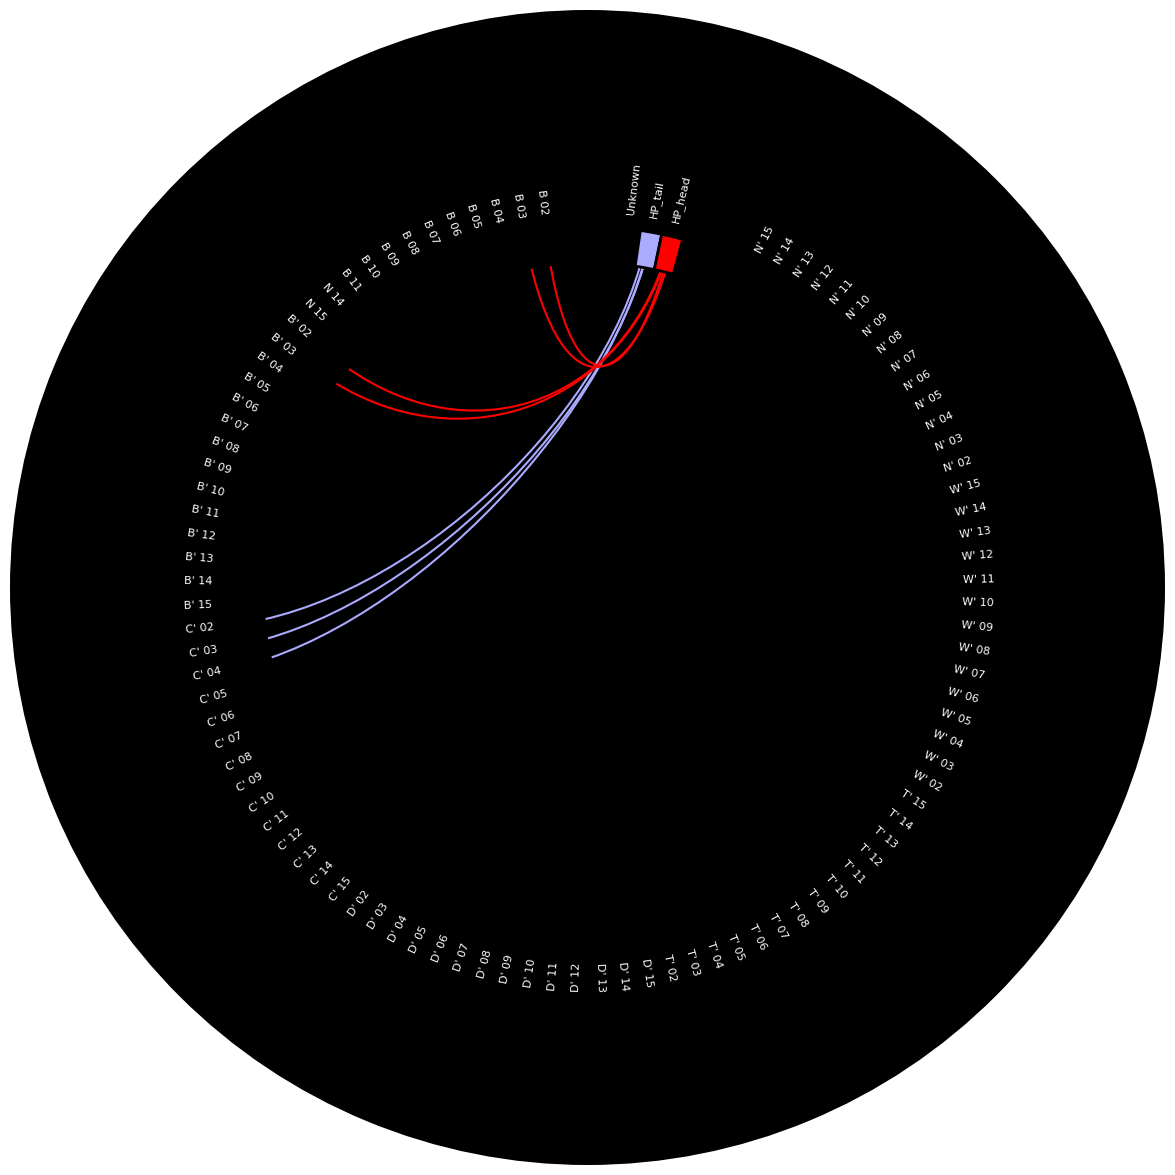

In [6]:
import matplotlib.pyplot as plt
import mne

all_labels = {k: v.split() for k, v in labels.items()}

fig, ax = plt.subplots(figsize=(20, 15), facecolor="none", subplot_kw=dict(polar=True))
kwargs = dict(ax=ax)
fig, ax = mne.viz.plot_channel_labels_circle(all_labels, colors, **kwargs)
fig.text(0.3, 0.9, "Anatomical Labels", color="white")
# plt.tight_layout()
plt.show()

Electrodes in the dataset: {'N', "W'", 'B', "D'", "B'", "T'", "C'", "N'"}


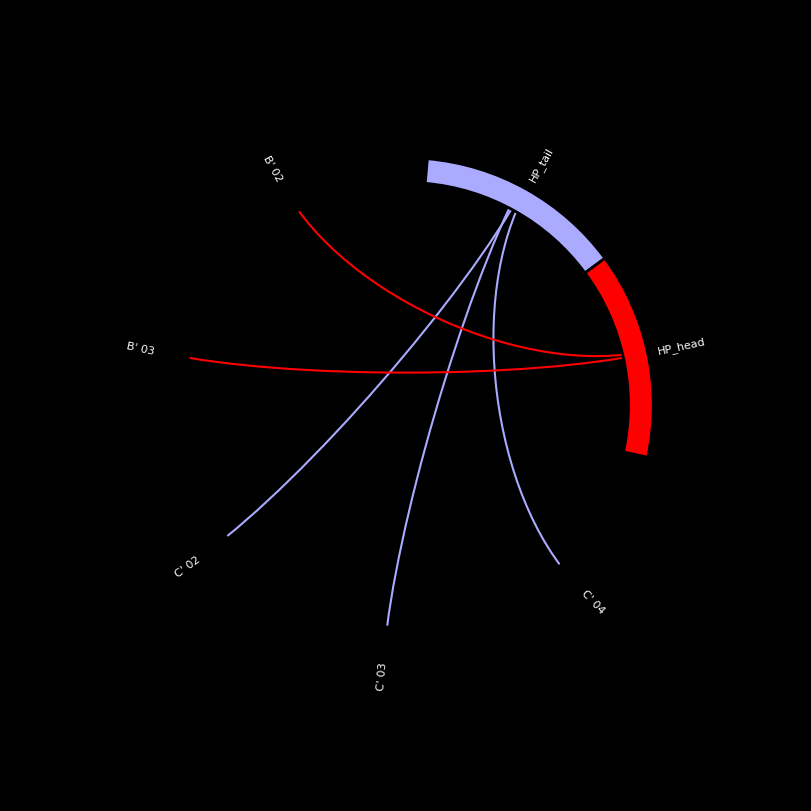

In [7]:
electrodes = set(
    ["".join([lttr for lttr in ch_name if not lttr.isdigit() and lttr != " "]) for ch_name in montage.ch_names])
print(f"Electrodes in the dataset: {electrodes}")

electrodes = ("A", "C", "B'", "C'")  # choose two for this example
picks = []
for elec in electrodes:
    picks.append([ch_name for ch_name in data.raw.ch_names if elec in ch_name])
picks = [item for sublist in picks for item in sublist]

labels_subset = {k: v for k, v in all_labels.items() if k in picks and v[0] != "Unknown"}
colors_subset = {k: v for k, v in colors.items() if k in np.ravel(list(labels_subset.values()))}

fig, ax = mne.viz.plot_channel_labels_circle(labels_subset, colors_subset, picks=picks)
fig.text(0.3, 0.9, "Anatomical Labels", color="white")
plt.show()

### Create new atlas with hippocampal subregions

In [8]:
# adding prefix 'Right' or 'Left' to assigned labels
for elec_name, dk_label in zip(data.df_chan.loc[idx_new_hippo, 'name'].to_list(), data.df_chan.loc[idx_new_hippo, 'DK_ROI'].to_list()):
    if 'right' in dk_label.lower():
        labels[elec_name] = 'Right_' + labels[elec_name]
    elif 'left' in dk_label.lower():
        labels[elec_name] = 'Left_' + labels[elec_name]

In [9]:
from IPython.display import display

# get IDs where the old labels are hippocampus
# idx = data.df_chan.loc[data.df_chan[['name', 'DK_ROI']].apply(lambda x: x.str.contains('hippocampus', case=False).any(), axis=1), ['name', 'DK_ROI']].index

# initiate new column
hp_sub_col = pd.Series([None] * len(data.df_chan), name='Subfields')
# assign subfield labels for hippocampal contacts
hp_sub_col.loc[idx_new_hippo] = data.df_chan.loc[idx_new_hippo, 'name'].map(labels)

# create new column for modified DK atlas and transfer old labels firstly
data.df_chan['DK_Subfields'] = data.df_chan['DK_ROI']
# now assign the new subfield labels
data.df_chan.loc[idx_new_hippo, 'DK_Subfields'] = hp_sub_col.loc[idx_new_hippo]

# check if all hippocampal contacts have been assigned a subfield label
# print("Check if all hippocampal contacts have been assigned a subfield label:")
# idx = data.df_chan.loc[data.df_chan['DK_ROI'].str.contains('hippocampus', case=False), ['name', 'DK_ROI', 'DK_Subfields']].index
# display(data.df_chan.loc[idx_combined, ['name', 'DK_ROI', 'DK_Subfields']])

# last check, compare the old atlas with the updated atlas. 
# This will show the difference between the atlases, which should only show the hippocampal subfields
print("Compare old atlas and updated atlas:")
# idx = np.where(data.df_chan['DK_ROI'] != data.df_chan['DK_Subfields'])[0]
display(data.df_chan.loc[idx_combined, ['name', 'DK_ROI', 'DK_Subfields']])

Compare old atlas and updated atlas:


,name,DK_ROI,DK_Subfields
0,B 02,Left_Hippocampus,Left_HP_head
1,B 03,Left_Hippocampus,Left_HP_head
12,B' 02,Right_Hippocampus,Right_HP_head
13,B' 03,Right_Hippocampus,Right_HP_head
14,B' 04,Right_Hippocampus,Right_Hippocampus
26,C' 02,Right_Hippocampus,Right_HP_tail
27,C' 03,Right_Hippocampus,Right_HP_tail
28,C' 04,Right_Hippocampus,Right_HP_tail


##### Last modifications in new atlas (optional)

In [10]:
idx = [14]

data.df_chan.loc[idx, 'DK_Subfields'] = 'Unknown'

print("Compare old atlas and updated atlas:")
display(data.df_chan.loc[idx_combined, ['name', 'DK_ROI', 'DK_Subfields']])

Compare old atlas and updated atlas:


,name,DK_ROI,DK_Subfields
0,B 02,Left_Hippocampus,Left_HP_head
1,B 03,Left_Hippocampus,Left_HP_head
12,B' 02,Right_Hippocampus,Right_HP_head
13,B' 03,Right_Hippocampus,Right_HP_head
14,B' 04,Right_Hippocampus,Unknown
26,C' 02,Right_Hippocampus,Right_HP_tail
27,C' 03,Right_Hippocampus,Right_HP_tail
28,C' 04,Right_Hippocampus,Right_HP_tail


### Save new atlas

Save the updated atlas in the channel dataframe with hippocampal subregions.

In [11]:
data.df_chan

,elec_index,elec_label,DK_ROI,Prob,Lobe,x17Networks,Prob_1,x7Networks,Prob_2,BN_atlas,...,Prob_5,Var16,data_chan,loc_1,loc_2,loc_3,name,HC left,HC right,DK_Subfields
0,2,102,Left_Hippocampus,0.98,H,NO_ROI,0.00,NO_ROI,0.00,Str_L_6_3,...,0.0,NaN,2,-30.196710,16.156342,-5.045925,B 02,True,False,Left_HP_head
1,3,103,Left_Hippocampus,0.73,H,NO_ROI,0.00,NO_ROI,0.00,Str_L_6_3,...,0.0,NaN,3,-33.345322,17.668876,-5.424282,B 03,True,False,Left_HP_head
2,4,104,Left_Cerebral_White_Matter,0.48,W,NO_ROI,0.00,NO_ROI,0.00,INS_L_6_4,...,0.0,NaN,4,-36.487648,19.209286,-5.821963,B 04,False,False,Left_Cerebral_White_Matter
3,5,105,Left_Cerebral_White_Matter,0.88,W,Networks_7,0.75,Networks_4,0.75,INS_L_6_4,...,0.0,NaN,5,-39.453272,20.673696,-6.209727,B 05,False,False,Left_Cerebral_White_Matter
4,6,106,Left_Cerebral_White_Matter,0.97,W,Networks_7,0.87,Networks_4,0.88,STG_L_6_5,...,0.0,NaN,6,-42.469230,22.161972,-6.613491,B 06,False,False,Left_Cerebral_White_Matter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,119,811,Right_Cerebral_White_Matter,0.60,W,Networks_5,0.91,Networks_3,0.98,SPL_R_5_2,...,0.0,NaN,119,10.515856,-36.743139,38.463777,N' 11,False,False,Right_Cerebral_White_Matter
92,120,812,Right_Cerebral_White_Matter,0.50,W,Networks_5,0.95,Networks_3,1.00,SPL_R_5_2,...,0.0,NaN,120,11.200195,-39.315922,40.794062,N' 12,False,False,Right_Cerebral_White_Matter
93,121,813,ctx_rh_superiorparietal,0.47,P,Networks_5,1.00,Networks_3,1.00,SPL_R_5_2,...,0.0,NaN,121,11.876524,-41.837500,43.070632,N' 13,False,False,ctx_rh_superiorparietal
94,122,814,ctx_rh_superiorparietal,0.61,P,Networks_5,1.00,Networks_3,1.00,SPL_R_5_2,...,0.0,NaN,122,12.563487,-44.379556,45.360802,N' 14,False,False,ctx_rh_superiorparietal


In [12]:
idx = np.unique(np.concatenate((idx_dk_hippo, idx_new_hippo, [14])))
data.df_chan.loc[idx, ['name', 'DK_ROI', 'DK_Subfields']]

,name,DK_ROI,DK_Subfields
0,B 02,Left_Hippocampus,Left_HP_head
1,B 03,Left_Hippocampus,Left_HP_head
12,B' 02,Right_Hippocampus,Right_HP_head
13,B' 03,Right_Hippocampus,Right_HP_head
14,B' 04,Right_Hippocampus,Unknown
26,C' 02,Right_Hippocampus,Right_HP_tail
27,C' 03,Right_Hippocampus,Right_HP_tail
28,C' 04,Right_Hippocampus,Right_HP_tail


In [13]:
data.save(path=path_data,
          postfix='preprocessed', 
          save_ieeg=False, 
          save_exp=False, 
          save_chan=True, 
          save_targets=False)

# Visualize New Hippocampal Labelling

### Bar plots

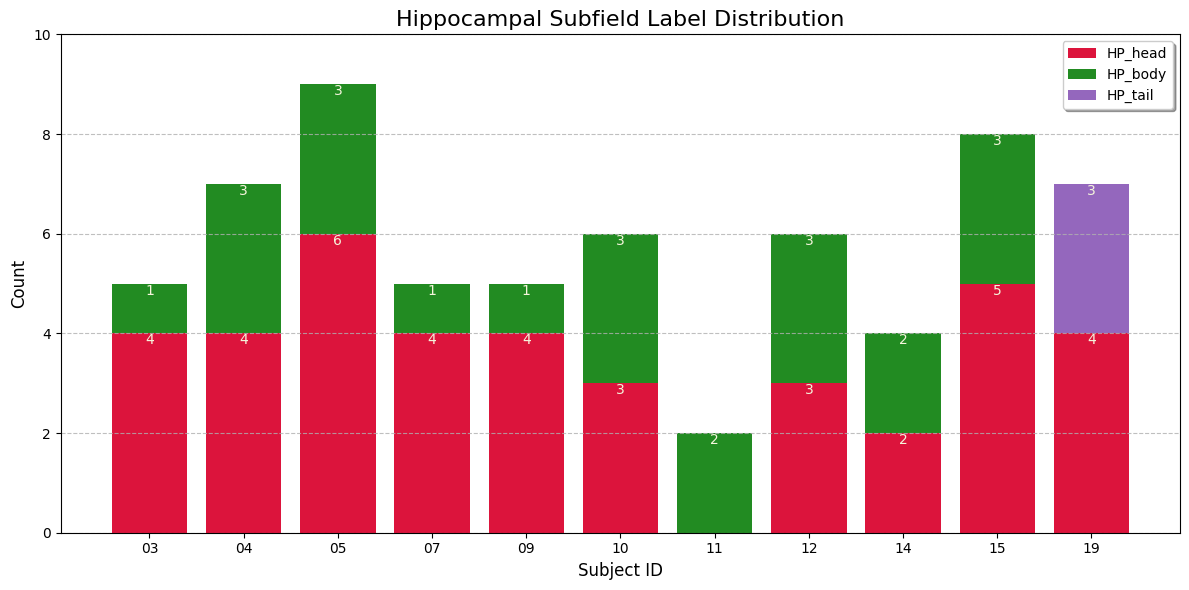

In [45]:
import neuropsy as npsy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)

subfield_labels = ['HP_head', 'HP_body', 'HP_tail'] 
color_palette   = {"HP_head": 'crimson',
                   "HP_body": 'forestgreen',
                   "HP_tail": 'tab:purple'}

#******** Get labels for each subject ********
dict_subject_labels = {}
for i, sub_id in enumerate(subject_ids):
    dict_subject_labels[sub_id] = {}
    
    # load subject data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_chan=True, load_exp=False, load_ieeg=False, load_targets=False)
    
    # only count hippocampal subfield labels
    for label in subfield_labels:
        # count number of contacts with label (do not differentiate between left and right)
        dict_subject_labels[sub_id][label] = len(data.df_chan.loc[data.df_chan['DK_Subfields'].str.contains(label, case=True)])
        # assign color to each label
        # dict_subject_labels[sub_id][f'{label}_color'] = color_palette[label]
        

#******** Plotting ********

# dict_n_trials_in_category = {}
# for cat in trial_categories:
#     dict_n_trials_in_category[cat] = data.df_exp[data.df_exp['Trial Category'] == cat].shape[0]

# count number of contacts with each label for each subject
HP_head         = [dict_subject_labels[sub_id]['HP_head'] for sub_id in subject_ids]
HP_body         = [dict_subject_labels[sub_id]['HP_body'] for sub_id in subject_ids]
HP_tail         = [dict_subject_labels[sub_id]['HP_tail'] for sub_id in subject_ids]
    
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(subject_ids, HP_head, label='HP_head', color=color_palette['HP_head'], edgecolor='none')
ax.bar(subject_ids, HP_body, label='HP_body', color=color_palette['HP_body'], edgecolor='none', bottom=HP_head)
ax.bar(subject_ids, HP_tail, label='HP_tail', color=color_palette['HP_tail'], edgecolor='none', bottom=[HP_head[s] + HP_body[s] for s in range(len(HP_head))])
ax.grid(axis='y', linestyle='--', alpha=0.8)
ax.legend(loc='upper right', shadow=True)

# sns.set_theme(style="whitegrid")
# ax = sns.countplot(df, x="Subject ID", hue='Trial Category', palette=colors)
# ax.set_xticks([int(x) for x in subject_ids], subject_ids)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=9, label_type='edge', color='beige', padding=-11)

for sub_id in subject_ids:
    if dict_subject_labels[sub_id]['HP_head'] > 0:
        ax.text(x=sub_id, y=dict_subject_labels[sub_id]['HP_head'], s=dict_subject_labels[sub_id]['HP_head'], ha='center', va='top', fontsize=10, color='beige')
    if dict_subject_labels[sub_id]['HP_body'] > 0:
        ax.text(x=sub_id, y=dict_subject_labels[sub_id]['HP_head']+dict_subject_labels[sub_id]['HP_body'], s=dict_subject_labels[sub_id]['HP_body'], ha='center', va='top', fontsize=10, color='beige')
    if dict_subject_labels[sub_id]['HP_tail'] > 0:
        ax.text(x=sub_id, y=dict_subject_labels[sub_id]['HP_head']+dict_subject_labels[sub_id]['HP_body']+dict_subject_labels[sub_id]['HP_tail'], s=dict_subject_labels[sub_id]['HP_tail'], ha='center', va='top', fontsize=10, color='beige')

ax.set_title('Hippocampal Subfield Label Distribution', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_ylim(0, 10)
plt.tight_layout()
# plt.savefig('/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/preprocessing/hippocampal subfield labelling/hippocampal_subfield_label_distribution.png', dpi=300)
plt.show()

In [40]:
data.df_chan.loc[data.df_chan['DK_Subfields'].str.contains('HP_body|HP_tail', case=True)]

,elec_index,elec_label,DK_ROI,Prob,Lobe,x17Networks,Prob_1,x7Networks,Prob_2,BN_atlas,...,Prob_5,Var16,data_chan,loc_1,loc_2,loc_3,name,HC left,HC right,DK_Subfields
26,46,402,Right_Hippocampus,0.62,H,NO_ROI,0.0,NO_ROI,0.0,Hipp_R_2_2,...,0.0,NaN,46,21.575091,-3.483249,3.259457,C' 02,False,True,Right_HP_tail
27,47,403,Right_Hippocampus,0.85,H,NO_ROI,0.0,NO_ROI,0.0,Hipp_R_2_2,...,0.0,NaN,47,25.046463,-3.596288,3.587894,C' 03,False,True,Right_HP_tail
28,48,404,Right_Hippocampus,0.59,H,NO_ROI,0.0,NO_ROI,0.0,Hipp_R_2_2,...,0.0,NaN,48,28.626360,-3.720143,3.948844,C' 04,False,True,Right_HP_tail


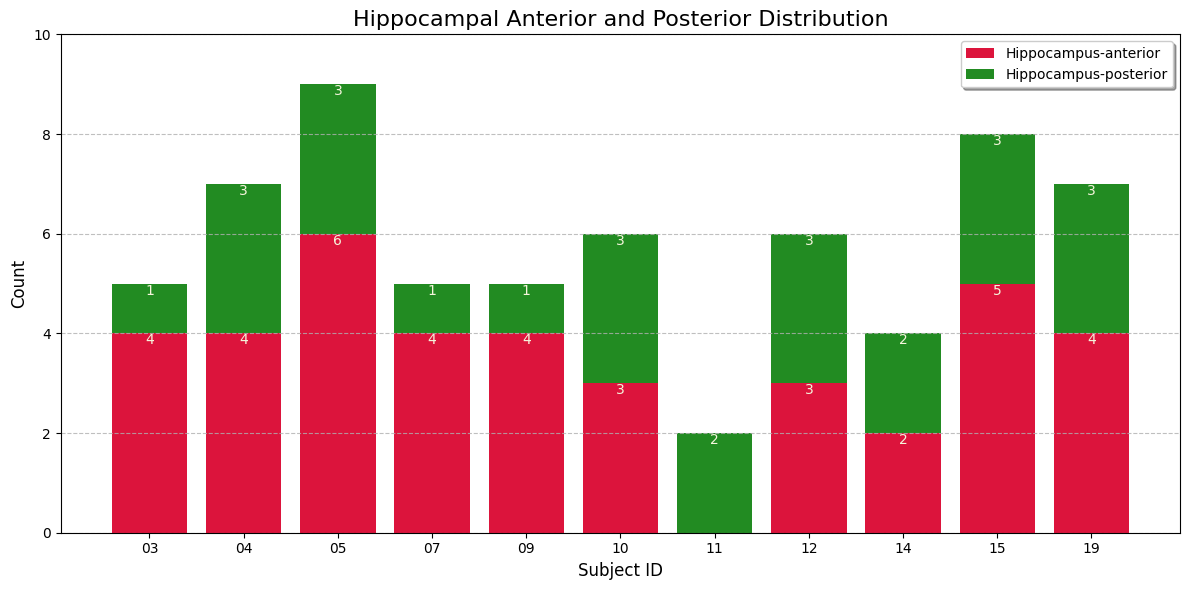

In [46]:
import neuropsy as npsy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)

subfield_labels = ['Hippocampus-anterior', 'Hippocampus-posterior'] 
color_palette   = {"Hippocampus-anterior": 'crimson',
                   "Hippocampus-posterior": 'forestgreen'}


#******** Get labels for each subject ********
dict_subject_labels = {}
for i, sub_id in enumerate(subject_ids):
    dict_subject_labels[sub_id] = {}
    
    # load subject data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_chan=True, load_exp=False, load_ieeg=False, load_targets=False)
    
    # only count hippocampal subfield labels
    for label in subfield_labels:
        # divide hippocampus into anterior (HP_head) and posterior (HP_body and HP_tail)
        if label == 'Hippocampus-anterior':
            dict_subject_labels[sub_id][label] = len(data.df_chan.loc[data.df_chan['DK_Subfields'].str.contains('HP_head', case=True)])
        elif label == 'Hippocampus-posterior':
            dict_subject_labels[sub_id][label] = len(data.df_chan.loc[data.df_chan['DK_Subfields'].str.contains('HP_body|HP_tail', case=True)])


#******** Plotting ********
# count number of contacts with each label for each subject
HP_anterior     = [dict_subject_labels[sub_id]['Hippocampus-anterior'] for sub_id in subject_ids]
HP_posterior    = [dict_subject_labels[sub_id]['Hippocampus-posterior'] for sub_id in subject_ids]
    
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(subject_ids, HP_anterior, label='Hippocampus-anterior', color=color_palette['Hippocampus-anterior'], edgecolor='none')
ax.bar(subject_ids, HP_posterior, label='Hippocampus-posterior', color=color_palette['Hippocampus-posterior'], edgecolor='none', bottom=HP_anterior)
ax.grid(axis='y', linestyle='--', alpha=0.8)
ax.legend(loc='upper right', shadow=True)

# sns.set_theme(style="whitegrid")
# ax = sns.countplot(df, x="Subject ID", hue='Trial Category', palette=colors)
# ax.set_xticks([int(x) for x in subject_ids], subject_ids)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=9, label_type='edge', color='beige', padding=-11)

for sub_id in subject_ids:
    if dict_subject_labels[sub_id]['Hippocampus-anterior'] > 0:
        ax.text(x=sub_id, y=dict_subject_labels[sub_id]['Hippocampus-anterior'], s=dict_subject_labels[sub_id]['Hippocampus-anterior'], ha='center', va='top', fontsize=10, color='beige')
    if dict_subject_labels[sub_id]['Hippocampus-posterior'] > 0:
        ax.text(x=sub_id, y=dict_subject_labels[sub_id]['Hippocampus-anterior']+dict_subject_labels[sub_id]['Hippocampus-posterior'], s=dict_subject_labels[sub_id]['Hippocampus-posterior'], ha='center', va='top', fontsize=10, color='beige')

ax.set_title('Hippocampal Anterior and Posterior Distribution', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_ylim(0, 10)
plt.tight_layout()
plt.savefig('/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/preprocessing/hippocampal subfield labelling/hippocampal_anterior_posterior_distribution.png', dpi=300)
plt.show()